# Setup

In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Filter contours based on area and aspect ratio
def is_valid_contour(contour, min_area, max_area, min_aspect_ratio, max_aspect_ratio):
    area = cv.contourArea(contour)
    if area < min_area or area > max_area:
        return False
    x, y, w, h = cv.boundingRect(contour)
    aspect_ratio = w / float(h)
    if aspect_ratio < min_aspect_ratio or aspect_ratio > max_aspect_ratio:
        return False
    return True

# Shape based image preprocessing

In [3]:
# Sharpening
def image_preprocessing(image):

    fixed_width=150
    scale_factor = fixed_width/image.shape[1] 
    upscaled_image = cv.resize(image, None,fx=scale_factor,fy=scale_factor, interpolation=cv.INTER_AREA)

    #Denoising
    denoised_img = cv.fastNlMeansDenoisingColored(upscaled_image, None, 10, 10, 7, 21)

    #Sharpening
    kernel = np.array([[0, -1, 0], 
                   [-1, 5,-1], 
                   [0, -1, 0]])
    sharpened_image = cv.filter2D(denoised_img, -1, kernel)

    return sharpened_image,scale_factor

# Edge Detection for Circle

In [4]:
def detect_edges(image):
    """
    Detect edges in an image using a pre-trained structured edge detection model.
    Returns:
        numpy.ndarray: Enroded Edges.
    """

    if image is None:
        raise ValueError("Failed to load the image.")

    image=image.astype(np.float32)/255

    # Load the pre-trained model
    model_path = 'model.yml'
    model = cv.ximgproc.createStructuredEdgeDetection(model_path)

    # Detect edges using the pre-trained model
    edges = model.detectEdges(image)

    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv.dilate(edges, kernel, iterations=1)
    eroded_edges = cv.erode(dilated_edges, kernel, iterations=1)
    
    return eroded_edges

# Edge Detection for Triangle

In [5]:
# canny edge detection
def canny_edge_detection(image):
    img = cv.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray, 100,200)
    return edges

In [6]:
def detect_circles(scale_factor,image,pre_image, dp=1, min_dist=100, param1=150, param2=20, min_radius=10, max_radius=100):
    """
    Detect circles in an edge-detected image using Hough Circle Transform with adjustable parameters.
    
    Parameters:
    - img: Original image (for drawing detected circles)
    - edges: Edge-detected image (for circle detection)
    - dp: Inverse ratio of accumulator resolution to image resolution (higher values -> smaller circles detected)
    - min_dist: Minimum distance between detected circle centers
    - param1: Higher threshold for Canny edge detection (lower = more sensitive to edges)
    - param2: Accumulator threshold for circle detection (lower = more circles, higher = stricter)
    - min_radius: Minimum radius of detected circles
    - max_radius: Maximum radius of detected circles
    
    Returns:
    - Image with largest circles detected contour , or None if no circle detected
    """
    edge_image=detect_edges(pre_image)
    # Convert edges to 8-bit single-channel (required by HoughCircles)
    edges_8bit = np.uint8(edge_image * 255)

    # Detect circles using Hough Transform with tunable parameters
    circles = cv.HoughCircles(edges_8bit, 
                              cv.HOUGH_GRADIENT, 
                              dp=dp, 
                              minDist=min_dist, 
                              param1=param1, 
                              param2=param2, 
                              minRadius=min_radius, 
                              maxRadius=max_radius)

    if circles is None:
        return None  # Return None if no circles are found

    # Convert the (x, y, radius) to integers
    circles = np.uint16(np.around(circles))
    
    # Find the largest circle based on radius
    largest_circle = max(circles[0, :], key=lambda x: x[2])
    center_x, center_y, radius = largest_circle

    ori_x = int(center_x / scale_factor)
    ori_y = int(center_y / scale_factor)
    ori_radius = int(radius / scale_factor)
    
    circle_contour = np.array([[ori_x - ori_radius, ori_y- ori_radius],
                                [ori_x + ori_radius, ori_y - ori_radius],
                                [ori_x + ori_radius, ori_y + ori_radius],
                                [ori_x - ori_radius, ori_y + ori_radius]], dtype=np.int32)
    circle_contour = np.array((circle_contour * scale_factor), dtype=np.int32)
    
    return circle_contour

In [7]:
def detect_triangles(pre_image):
    # Perform Canny edge detection
    tri_edges = canny_edge_detection(pre_image)
    
    # Find contours from the edge-detected image
    contours, _ = cv.findContours(tri_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Initialize variables to store the largest triangle contour
    largest_area = 0
    largest_triangle_contour = None

    # Define area and aspect ratio thresholds
    min_area = 500
    max_area = 0.25 * (min(pre_image.shape[:2]) ** 2)
    min_aspect_ratio = 1 / 1.9
    max_aspect_ratio = 1.9

    # Iterate over all detected contours
    for contour in contours:
        # Apply Douglas-Peucker algorithm to simplify the contour
        epsilon = 0.03 * cv.arcLength(contour, True)  # Precision parameter
        approx_contour = cv.approxPolyDP(contour, epsilon, True)

        # Check if the simplified contour has 3 vertices (i.e., forms a triangle)
        if len(approx_contour) == 3:
            # Validate the contour using the is_valid_contour function
            if is_valid_contour(approx_contour, min_area, max_area, min_aspect_ratio, max_aspect_ratio):
                area = cv.contourArea(approx_contour)

                # Check if this triangle has the largest area found so far
                if area > largest_area:
                    largest_area = area
                    largest_triangle_contour = approx_contour

    if largest_triangle_contour is not None:
            # Create contour for the triangle
            triangle_contour = np.array(largest_triangle_contour, dtype=np.int32)
            # Return contour and the bounding box
            return triangle_contour
        
    else:
        return None

In [8]:
# combine the results of 2 shape detectors
def integrate_circle_tri(tri_cnt, circle_cnt):
    if circle_cnt is not None and tri_cnt is not None:
        # compare the area
        if cv.contourArea(circle_cnt) >= cv.contourArea(tri_cnt):
            output = circle_cnt
        else:
            output = tri_cnt

    elif circle_cnt is not None and tri_cnt is None:
        output = circle_cnt

    elif circle_cnt is None and tri_cnt is not None:
        output = tri_cnt

    else:
        output = np.array([])

    return output

    
def integrate_shape_detections(pre_image):
    # Detect circles and triangles
    circle_contour = detect_circles(scale_factor,image, pre_image)
    triangle_contour = detect_triangles(pre_image)

    # Integrate results based on area
    final_contour = integrate_circle_tri(triangle_contour, circle_contour)

    output_image = pre_image.copy()

    if len(final_contour) > 0:
        x, y, w, h = cv.boundingRect(final_contour)
        cv.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        return final_contour ,output_image
        
    else:
        return None,output_image

# Color Based Image Preprocessing

In [9]:
def image_enhancement(image):

    fixed_width=150
    scale_factor = fixed_width/image.shape[1] 
    resized_image = cv.resize(image, None,fx=scale_factor,fy=scale_factor, interpolation=cv.INTER_AREA)

    # denoising
    img = cv.fastNlMeansDenoisingColored(resized_image, None, 10, 10, 7, 21)
    
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv_img)
    gamma = 0.5
    saturation_scale = 1.5
    value_scale = v / 255.0
    
    # Adjust saturation
    s_adjusted = np.clip(s * saturation_scale, 0, 255).astype(np.uint8)
    
    # Apply gamma correction to Value channel
    v_adjusted = np.clip(cv.pow(v * value_scale, gamma) * 255.0, 0, 255).astype(np.uint8)
    
    hsv_adjusted = cv.merge([h, s_adjusted, v_adjusted])
    enhanced_img = cv.cvtColor(hsv_adjusted, cv.COLOR_HSV2BGR)
   
    return enhanced_img , scale_factor

# Color Segmentation

In [10]:
def color_segmentation(image):
    
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV) 
    
    lower_red1 = np.array([0, 100, 90])
    upper_red1 = np.array([18, 255, 255])
    lower_red2 = np.array([144, 100, 90])
    upper_red2 = np.array([180, 255, 255])
    mask_red1 = cv.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv.bitwise_or(mask_red1, mask_red2)

    lower_yellow = np.array([90, 102, 102])
    upper_yellow = np.array([126, 255, 255])
    yellow_mask = cv.inRange(hsv, lower_yellow, upper_yellow)
    
    lower_blue = np.array([16, 90, 102])
    upper_blue = np.array([32, 255, 255])
    blue_mask = cv.inRange(hsv, lower_blue, upper_blue)

    mask = cv.bitwise_or(red_mask, blue_mask)
    mask = cv.bitwise_or(mask, yellow_mask)

    #ADD BLACK COLOR
    
    segmented_image = cv.bitwise_and(image, image, mask=mask)
    return segmented_image, mask

# Color Detection

In [11]:
def color_detection(image):
    
    segmented_image, mask = color_segmentation(image)
    
    ret, binary_image = cv.threshold(mask, 175, 255, cv.THRESH_BINARY)
    
    #Morphological Transform
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    cleaned_image = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel)
    cleaned_image = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)
    
    contours, _ = cv.findContours(cleaned_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    min_area = 800
    max_area = 0.25 * (min(image.shape[:2]) ** 2)
    min_aspect_ratio = 1/1.9
    max_aspect_ratio = 1.9
    
    largest_contour= None
    
    valid_contours = []
    for contour in contours:
        if is_valid_contour(contour, min_area, max_area, min_aspect_ratio, max_aspect_ratio):
            valid_contours.append(contour)
    
    if valid_contours:
        largest_contour = max(valid_contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(largest_contour)

    if largest_contour is not None:
        largest_contour = np.array(largest_contour, dtype=np.int32)
        return largest_contour
    else:
        return None

# Integrate the Edge and Color Result

In [12]:
def integrate_edge_color(output1, output2):
    if output1 is None and output2 is None:
        return np.array([])
    
    if output1 is None or output2 is None or (isinstance(output1, np.ndarray) and len(output1) == 0) or (isinstance(output2, np.ndarray) and len(output2) == 0):
        return output1 if output1 is not None else output2

    # If both outputs are valid contours, compare their areas
    if isinstance(output1, np.ndarray) and isinstance(output2, np.ndarray):
        if len(output1) > 0 and len(output2) > 0:
            area1 = cv.contourArea(output1)
            area2 = cv.contourArea(output2)
            return output1 if area1 > area2 else output2

# IOU compute

In [13]:
# Calculate the IoU between two bounding boxes
def computeIOU(boxA, boxB):
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

# Dice Coefficient

In [14]:
def compute_dice_coefficient(ground_truth_box, predicted_box):
    # Unpack the coordinates
    x_gt_start, y_gt_start, x_gt_end, y_gt_end = ground_truth_box
    x_pred_start, y_pred_start, x_pred_end, y_pred_end = predicted_box

    # Compute the intersection
    x_inter_start = max(x_gt_start, x_pred_start)
    y_inter_start = max(y_gt_start, y_pred_start)
    x_inter_end = min(x_gt_end, x_pred_end)
    y_inter_end = min(y_gt_end, y_pred_end)

    # Calculate intersection area
    inter_width = max(0, x_inter_end - x_inter_start)
    inter_height = max(0, y_inter_end - y_inter_start)
    intersection_area = inter_width * inter_height

    # Calculate the areas of the ground truth and predicted boxes
    ground_truth_area = (x_gt_end - x_gt_start) * (y_gt_end - y_gt_start)
    predicted_area = (x_pred_end - x_pred_start) * (y_pred_end - y_pred_start)

    # Compute the Dice coefficient
    dice_coeff = (2 * intersection_area) / (ground_truth_area + predicted_area)
    
    return dice_coeff

In [15]:
annotations = pd.read_csv('TsignRecgTest1994Annotation.txt', sep=";", header=None)
annotations.drop([8], axis=1, inplace=True)
annotations.columns = ["filenames", "width", "height", "x_start", "y_start", "x_end", "y_end", "labels"]
annotations.set_index("filenames", inplace=True)

# Main Operation

In [16]:
img_dir = "image/"

IOUs = []
img_iou_zero = []
files_no_det = []
box_image = []
Dices = []
i=0

# Get a list of all image files in the directory
all_files = os.listdir(img_dir)

for filename in all_files:
    image = cv.imread(os.path.join(img_dir,filename))
    if image is None:
        print("No such file")
        break
    i+=1
    pre_image, scale_factor = image_preprocessing(image)
    shape_cnt , output_image = integrate_shape_detections(pre_image)
    enh_img, scale_factor = image_enhancement(image)
    color_cnt = color_detection(enh_img)

    final_output = integrate_edge_color(color_cnt,shape_cnt)
    if len(final_output) == 0:
        IOUs.append(0)
        Dices.append(0)
        box_image.append(image)
        files_no_det.append(filename)
    else:
        x, y, w, h = cv.boundingRect(final_output)
        # Convert bounding box coordinates back to original image size
        original_x = int(x / scale_factor)
        original_y = int(y / scale_factor)
        original_w = int(w / scale_factor)
        original_h = int(h / scale_factor)
    
        image_with_boxes = image.copy()
        # Draw bounding box around the detected contour in the original image
        cv.rectangle(image_with_boxes, (original_x, original_y), (original_x + original_w, original_y + original_h), (255, 255, 255), 2)
    
        if filename in annotations.index:
            ground_truth = annotations.loc[filename]
            ground_truth_box = (ground_truth["x_start"], ground_truth["y_start"], ground_truth["x_end"], ground_truth["y_end"])
            predicted_box = (original_x, original_y,original_x + original_w, original_y + original_h)
            iou = computeIOU(ground_truth_box, predicted_box)
            dice = compute_dice_coefficient(ground_truth_box, predicted_box)
            cv.rectangle(image_with_boxes, ( ground_truth_box[0],  ground_truth_box[1]), ( ground_truth_box[2],  ground_truth_box[3]), (255, 0, 0), 2)
            cv.putText(image_with_boxes, f"IOU: {iou:.3f}", (12, 12), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0,0))
            
            IOUs.append(iou)
            Dices.append(dice)
            box_image.append(image_with_boxes)
            if iou==0:
                img_iou_zero.append(image_with_boxes)


# IOU statistic

In [17]:
IOU_series = pd.Series(IOUs)
IOU_series.describe()

count    1994.000000
mean        0.722921
std         0.206330
min         0.000000
25%         0.612711
50%         0.794337
75%         0.874178
max         0.981818
dtype: float64

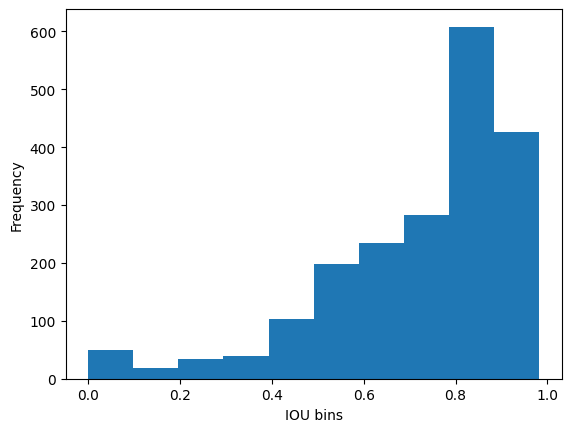

In [18]:
# Histogram
IOU_series.hist()
plt.xlabel("IOU bins"), plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [19]:
len(img_iou_zero)

2

In [20]:
len(files_no_det)

24

# Number of Images IOU >= 0.5

In [21]:
arr_IOU = np.array(IOUs)
(arr_IOU>=0.5).sum()

1732

# Overall Accuracy

In [22]:
print(f"The proportion of good segmentation: {round((arr_IOU>=0.5).sum() / 1994, 4)}")

The proportion of good segmentation: 0.8686


# Images that no detected

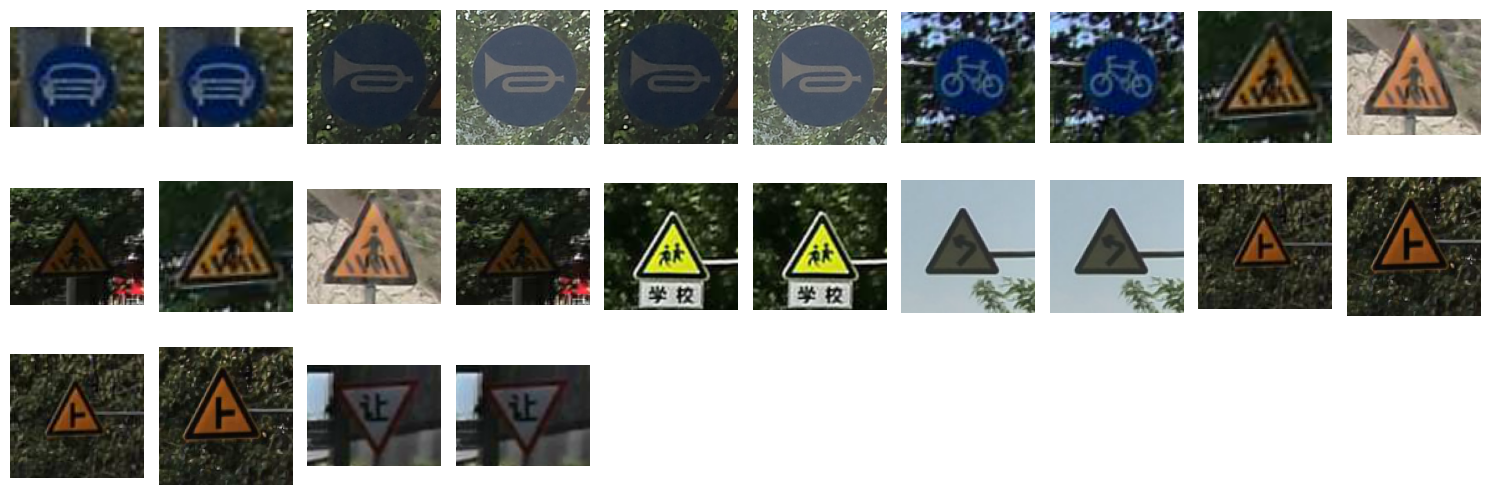

In [33]:
# Set up the plot
plt.figure(figsize=(15,12))

for i , img in enumerate(files_no_det):
    image = cv.imread(os.path.join(img_dir,img))
    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    # Create a subplot for each image
    plt.subplot(7,10, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis labels
    
# Show the plot with the images
plt.tight_layout()
plt.show()

# Images with 0 IOU

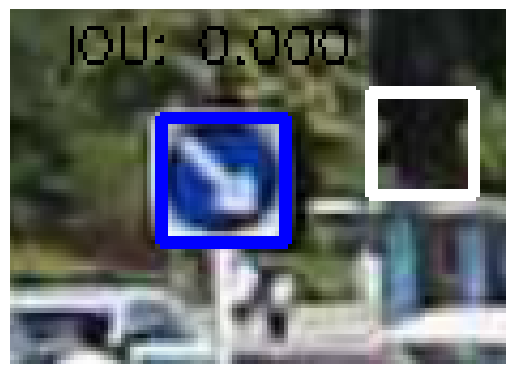

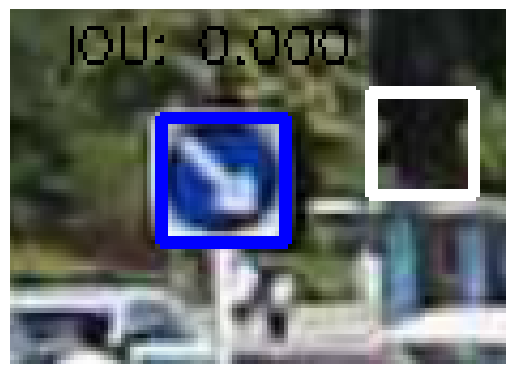

In [31]:
for img in img_iou_zero:
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Display Images with IOU >=0.5

In [26]:
#Save File
#html_content = df.to_html(escape=False)
#th open("detection_results.html", "w") as f:
#   f.write(html_content)